# Block-Silhouette Analysis for CogSci 2020

## Import and set up directories

In [96]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
proj_dir = os.path.abspath('../..')

if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from random import random

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import blockworld_helpers as utils
import drawing_utils as drawing
import importlib

In [97]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

## Load Data

In [98]:
iteration_name = 'Exp2Pilot3'
num_trials = 24 #for sanity checks

In [99]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

51 participants total


In [105]:
df['targetNumber'] = df['targetName'].apply(lambda x: x[-2:])

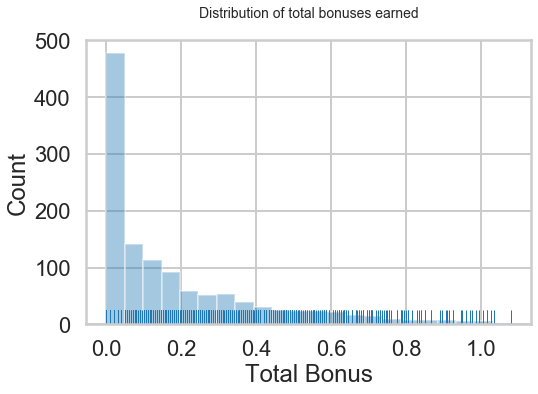

In [100]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.distplot(df['score'],
                rug=True,
                kde=False)
plt.ylabel('Count')
plt.xlabel('Total Bonus')
plt.title('Distribution of total bonuses earned\n',{'fontsize': 14})
plt.tight_layout()

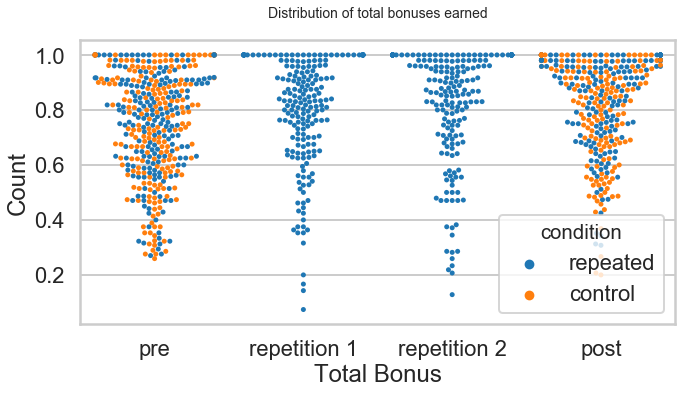

In [101]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.swarmplot(x = 'phase_extended',
                  y = 'rawF1DiscreteScore',
                  hue = 'condition',
            data = df)
plt.ylabel('Count')
plt.xlabel('Total Bonus')
#plt.xticks(np.arange(df.gameID.nunique()),[str(n) for n in np.arange(df.gameID.nunique())])
plt.title('Distribution of total bonuses earned\n',{'fontsize': 14})
plt.tight_layout()


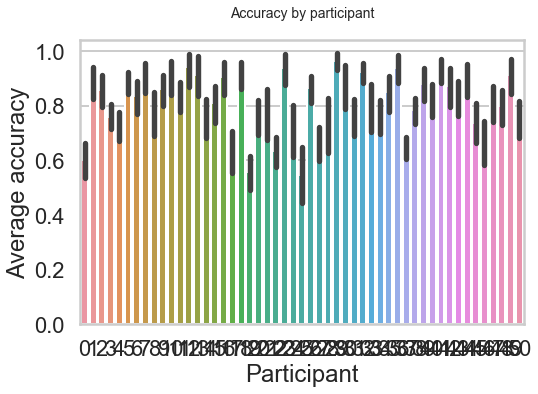

In [102]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x = 'gameID',
                y = 'rawF1DiscreteScore',
                #hue = 'phase',
                #hue = 'repetition',
                data = df)
plt.ylabel('Average accuracy')
plt.xlabel('Participant')
plt.xticks(np.arange(df.gameID.nunique()),[str(n) for n in np.arange(df.gameID.nunique())])
plt.title('Accuracy by participant\n',{'fontsize': 14})
plt.tight_layout()

ValueError: cannot convert float NaN to integer

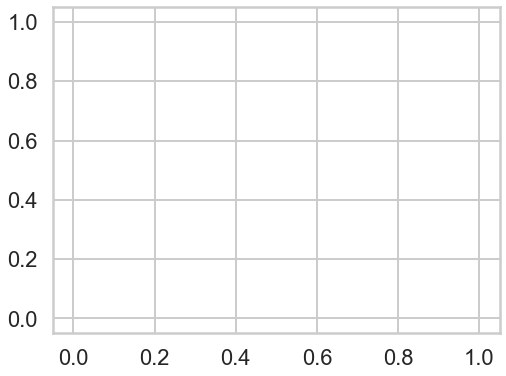

In [106]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.distplot(df['rawF1DiscreteScore'],
                rug=True,
                kde=False)
plt.ylabel('Count')
plt.xlabel('Accuracy')
plt.title('Distribution of Discrete F1 Scores\n',{'fontsize': 14})
plt.tight_layout()


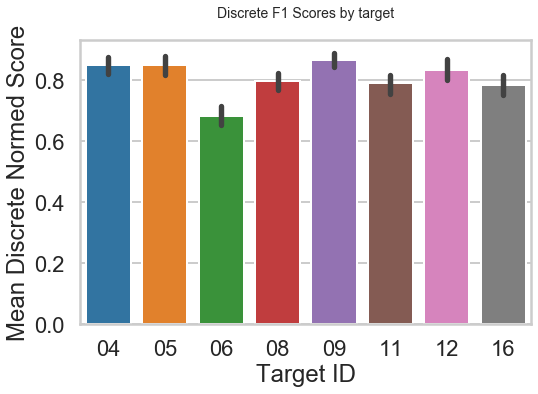

In [107]:
names = df.targetName.unique()
names.sort()
structure_numbers = list(map(lambda x: x[-2:],names))

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x = 'targetName',
                y = 'rawF1DiscreteScore',
                order = names,
                data = df)
plt.ylabel('Mean Discrete Normed Score')
plt.xlabel('Target ID')
plt.xticks(np.arange(len(names)),structure_numbers)
plt.title('Discrete F1 Scores by target\n',{'fontsize': 14})
plt.tight_layout()

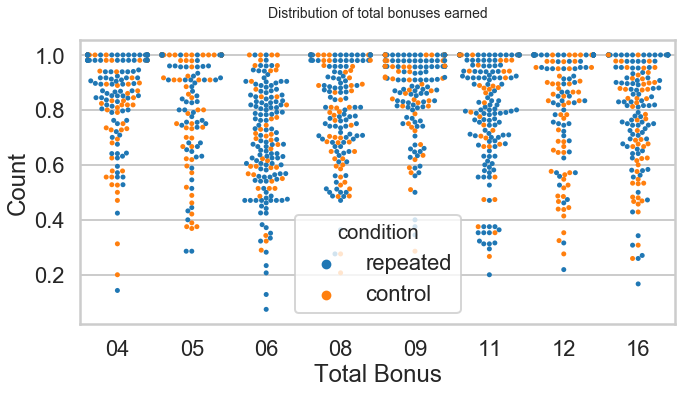

In [118]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.swarmplot(x = 'targetNumber',
                  y = 'rawF1DiscreteScore',
                  hue = 'condition',
            data = df)
plt.ylabel('Count')
plt.xlabel('Total Bonus')
#plt.xticks(np.arange(df.gameID.nunique()),[str(n) for n in np.arange(df.gameID.nunique())])
plt.title('Distribution of total bonuses earned\n',{'fontsize': 14})
plt.tight_layout()

In [ ]:
# exclude outliers with low mean normed score
remove_outliers = False

if remove_outliers:

    threshold = 0.7

    df_means = df.groupby(by=['gameID'])['normedScoreDiscrete'].apply(np.mean).reset_index()
    low_scores = df_means[df_means.normedScoreDiscrete< threshold]['gameID'] 
    print(low_scores)
    df = df[~df.gameID.isin(low_scores)]
    dfi = dfi[~dfi.gameID.isin(low_scores)]
    dfs = dfs[~dfs.gameID.isin(low_scores)]

    n = df.gameID.nunique()
    print(str(n) + ' participants with score <'+str(threshold)+' and full set of trials')



In [ ]:
# Exclude outliers with low total bonus

remove_outliers = False

if remove_outliers:

    low_scores = df[(df.trialNum == (num_trials-1)) & (df.score == 0)]['gameID'] # people who achieved zero bonus


    df = df[~df.gameID.isin(low_scores)]
    dfi = dfi[~dfi.gameID.isin(low_scores)]
    dfs = dfs[~dfs.gameID.isin(low_scores)]

    n = df.gameID.nunique()
    print(str(n) + ' participants with score > 0 and full set of trials')


In [9]:
if False:
    importlib.reload(drawing)
    drawing.draw_all_trials(df, figsize=(20,80))

In [10]:
df[df.normedScoreDiscrete<0].iloc[[34]]

,Unnamed: 0,gameID,trialNum,phase,condition,eventType,targetName,repetition,targetID,nullScore,...,numRepetitions,bonusThresholdLow,bonusThresholdMid,bonusThresholdHigh,timeThresholdYellow,timeThresholdRed,rawF1DiscreteScore,jaccardDiscrete,phase_extended,phase_number
1132,1109,9659-5abde78c-ee50-4470-8814-d0f698fcd93b,4,pre,repeated,trial_end,hand_selected_011,0,5,0.158151,...,2,0.75,0.88,0.95,30000,15000,0.650794,0.482353,pre,0


In [ ]:
importlib.reload(drawing)
drawing.draw_trials(df[df.normedScoreDiscrete<0], figsize=(20,80))

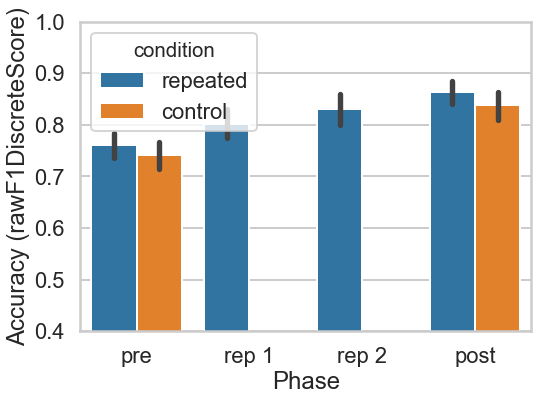

In [12]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x='phase_extended', 
                y='rawF1DiscreteScore', 
                hue='condition', 
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Phase')
plt.ylim(0.4,1)
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
plt.tight_layout()


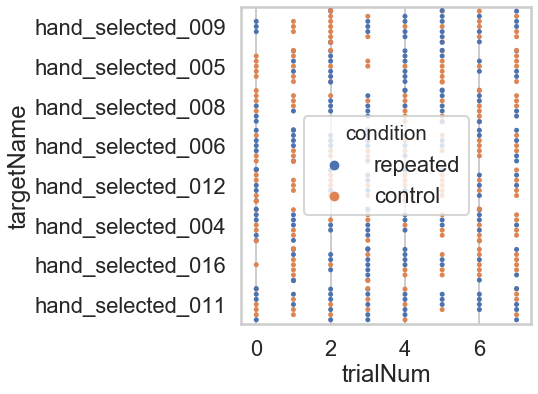

In [255]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.swarmplot(y='targetName', 
                x='trialNum', 
                hue='condition', 
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);
plt.tight_layout()


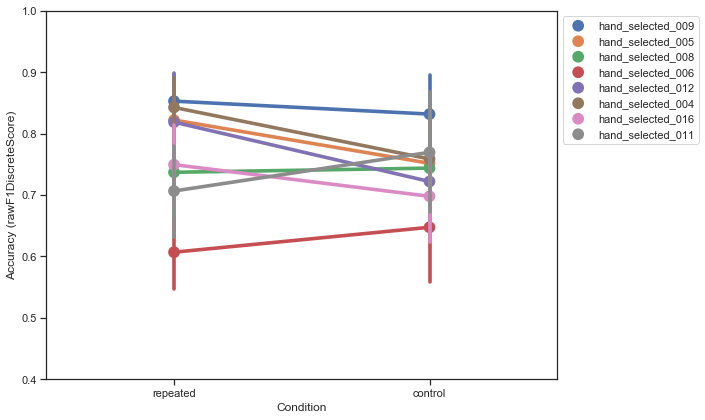

In [259]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
sns.set(style="ticks", rc={"lines.linewidth": 2})
c = sns.pointplot(x='condition', 
                y='rawF1DiscreteScore', 
                hue='targetName', 
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Condition')
plt.ylim(0.4,1)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

/Users/will/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  del sys.path[0]


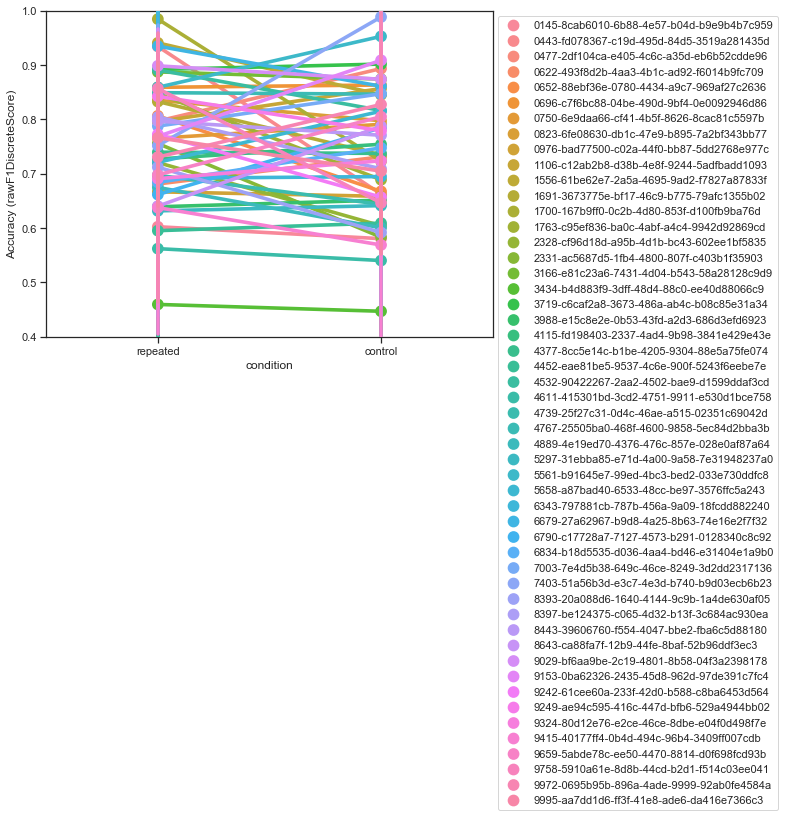

In [227]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
sns.set(style="ticks", rc={"lines.linewidth": 2})
c = sns.pointplot(x='condition', 
                y='rawF1DiscreteScore', 
                hue='gameID', 
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.ylim(0.4,1)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

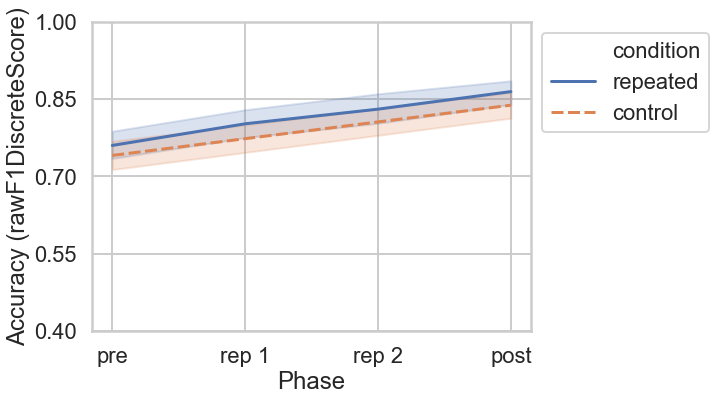

In [229]:
# Accuracy by phase
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='phase_number', 
                y='rawF1DiscreteScore', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
plt.yticks(np.linspace(.4,1,5))
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

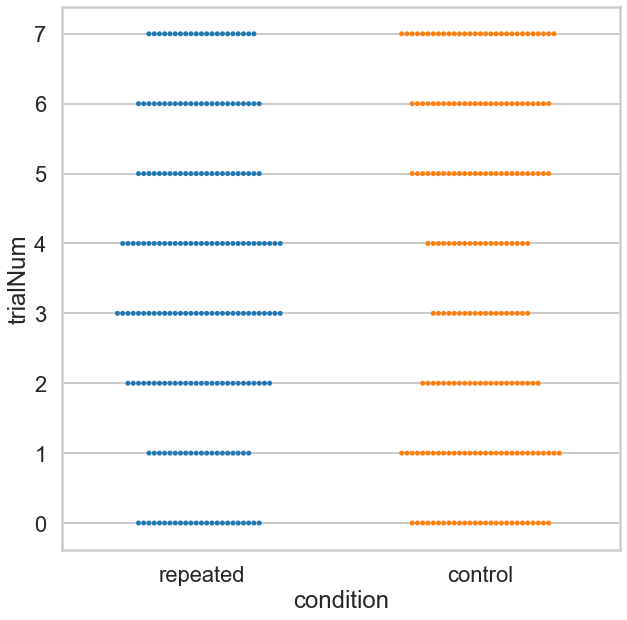

In [173]:
# Build Time over trials
fig = plt.figure(figsize=(10,10))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
#sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.swarmplot(x='condition',
                y='trialNum', 
                dodge=True,
                linewidth=0,
                #palette="ch:r=-.3,d=.1_r",
                #kind='point', 
                data=df[df.phase=='pre'])

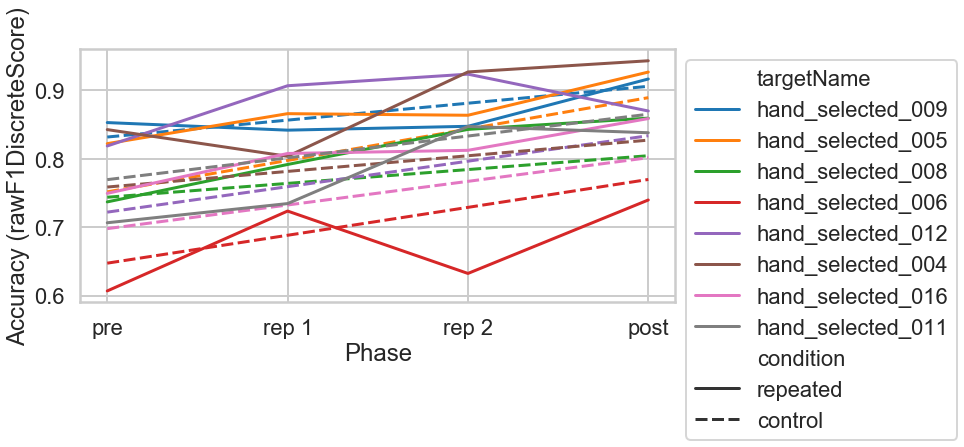

In [79]:
# Accuracy by phase
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='phase_number', 
                y='rawF1DiscreteScore', 
                hue='targetName',
                style='condition',
                ci = None,
                #style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

<Figure size 720x432 with 0 Axes>

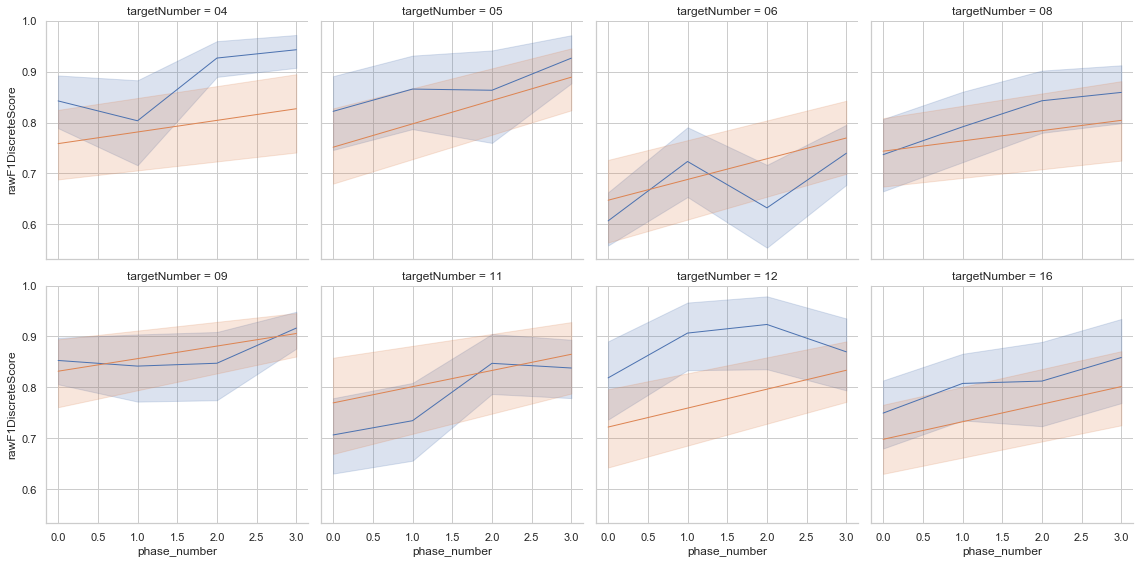

In [223]:
# def target_plot(df, x=  **kwargs):
#     sns.lineplot(df, x=, **kwargs)

# g = sns.FacetGrid(tips, col="sex", height=4)
# g.map(quantile_plot, "total_bill");

df['targetNumber'] = df['targetName'].apply(lambda x: x[-2:])

sns.set_style('whitegrid')
fig = plt.figure(figsize=(10,6))
g = sns.FacetGrid(df, col="targetNumber", col_wrap=4, height=4, hue="condition")
g.map(sns.lineplot, "phase_number", "rawF1DiscreteScore");

<Figure size 720x432 with 0 Axes>

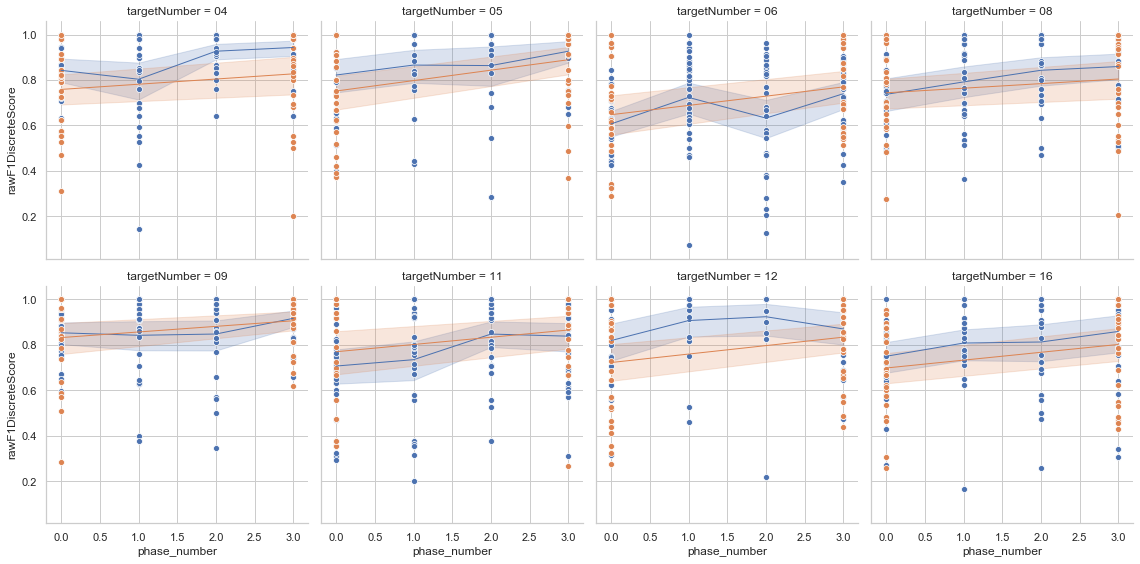

In [226]:
# def target_plot(df, x=  **kwargs):
#     sns.lineplot(df, x=, **kwargs)

# g = sns.FacetGrid(tips, col="sex", height=4)
# g.map(quantile_plot, "total_bill");

df['targetNumber'] = df['targetName'].apply(lambda x: x[-2:])

sns.set_style('whitegrid')
fig = plt.figure(figsize=(10,6))
g = sns.FacetGrid(df, col="targetNumber", col_wrap=4, height=4, hue="condition")
g.map(sns.lineplot, "phase_number", "rawF1DiscreteScore");
g.map(sns.scatterplot, "phase_number", "rawF1DiscreteScore");

In [66]:
# Number of blocks

df[df.condition=='control']['targetName'].value_counts()

hand_selected_012    62
hand_selected_005    58
hand_selected_016    54
hand_selected_008    52
hand_selected_004    50
hand_selected_009    50
hand_selected_006    42
hand_selected_011    40
Name: targetName, dtype: int64

In [63]:
df[df.condition=='repeated']['targetName'].value_counts()

hand_selected_011    124
hand_selected_006    120
hand_selected_004    104
hand_selected_009    104
hand_selected_008    100
hand_selected_016     96
hand_selected_005     88
hand_selected_012     80
Name: targetName, dtype: int64

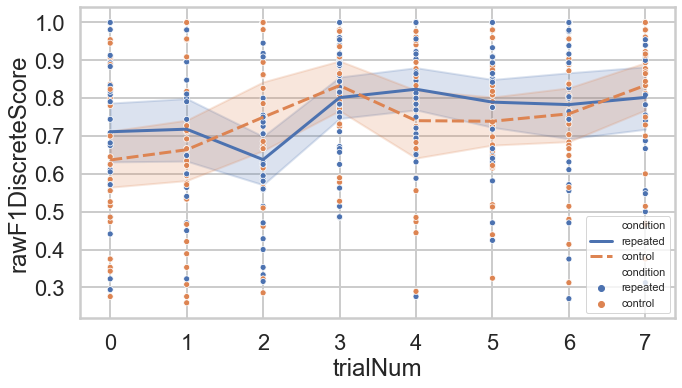

In [216]:
# Accuracy by phase
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='trialNum', 
                y='rawF1DiscreteScore', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Trial')
#plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.scatterplot(x='trialNum', 
                y='rawF1DiscreteScore', 
                hue='condition',
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);

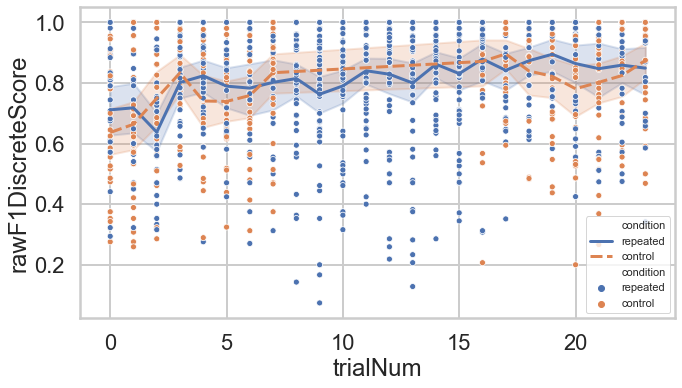

In [242]:
# Accuracy by phase
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='trialNum', 
                y='rawF1DiscreteScore', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Trial')
#plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.scatterplot(x='trialNum', 
                y='rawF1DiscreteScore', 
                hue='condition',
                #kind='point', 
                #legend=False,
                data=df);

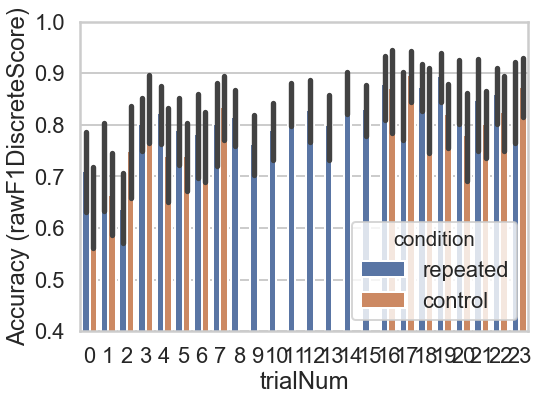

In [241]:
fig = plt.figure(figsize=(8,6))
sns.set(style="ticks", rc={"lines.linewidth": 0.5})
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x='trialNum', 
                y='rawF1DiscreteScore', 
                hue='condition', 
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.ylim(0.4,1)
plt.tight_layout()


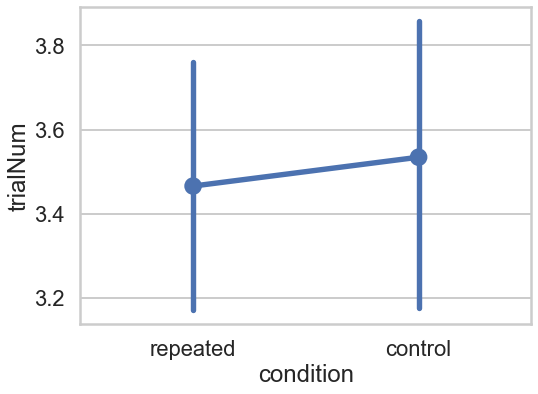

In [256]:
#double check that repeated condition isn't coming after control

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.pointplot(x='condition', 
                y='trialNum', 
                #hue='condition',
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);

#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

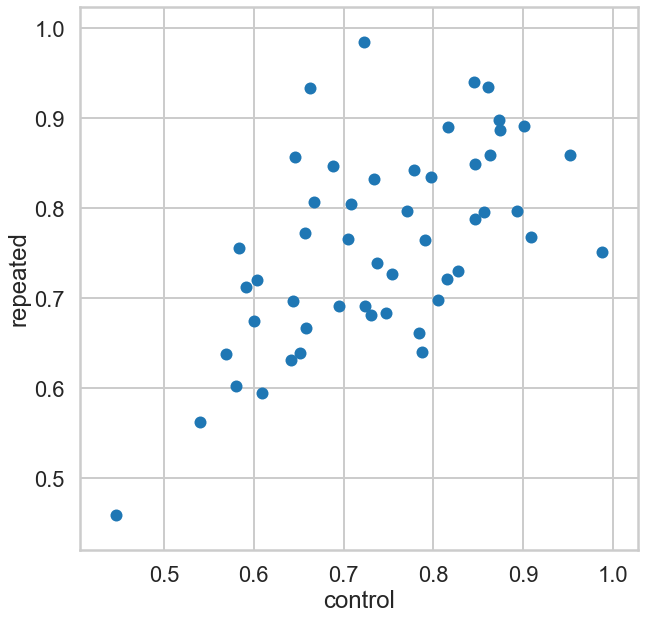

In [54]:
df_pre = df[df.phase=='pre']
df_grouped_pre = df_pre.groupby(by=['gameID','condition'])['rawF1DiscreteScore'].apply(np.mean).reset_index()

df_grouped_pre_wide = df_grouped_pre.pivot(index='gameID', columns='condition',values='rawF1DiscreteScore')


# Build Time over trials
fig = plt.figure(figsize=(10,10))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
#sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='control', 
                    y='repeated', 
                    #hue='repeated',
                    #size= 'numBlocks',
                    #sizes=(16,16),
                    linewidth=0,
                    #palette="ch:r=-.3,d=.1_r",
                    #kind='point', 
                    data=df_grouped_pre_wide)


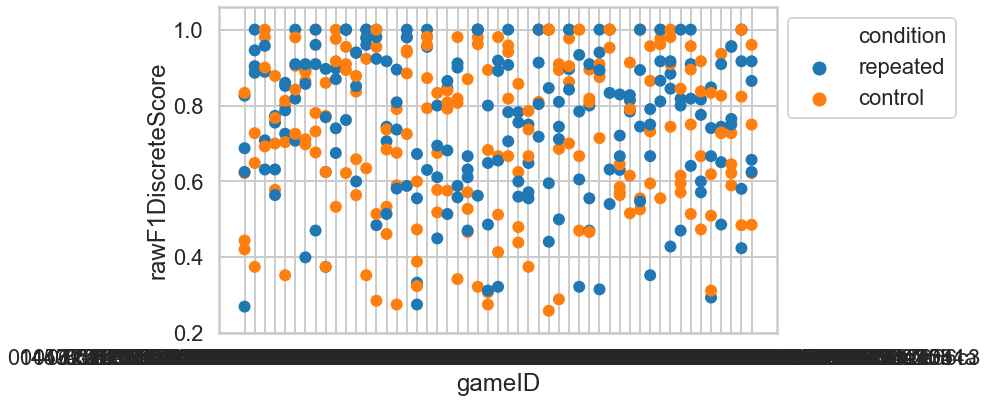

In [14]:
# what is explaining



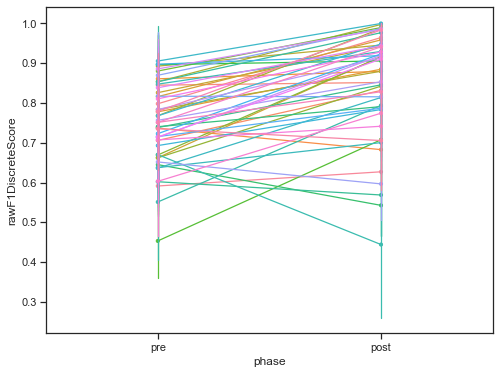

In [181]:
# Individual accuracy, pre- vs. post-

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='rawF1DiscreteScore', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[df.phase.isin(['pre','post'])])
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)


In [ ]:
# Individual accuracy, all phases

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='rawF1DiscreteScore', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

In [ ]:
# Number of blocks placed by phase
# Should we control for fallen structures? 

df.groupby(by='phase_extended').apply(np.mean)


fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='phase_number', 
                y='numBlocks', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('numBlocks')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

In [ ]:
# Individual block use pre- and post- 

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='numBlocks', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[df.phase.isin(['pre','post'])])
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

In [ ]:
# Individual block use, all phases

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='numBlocks', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x='repetition', 
                y='timeToBuild', 
                hue='condition', 
                #kind='point', 
                #legend=False,
                data=df)
plt.ylabel('time to build (ms)')
plt.xlabel('Repetition')
plt.title('Build time by repetition (control repetition 1 happens at same time as repeated repetition 3)\n',{'fontsize': 16})
#plt.ylim(0.4,1)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.scatterplot(x='rawF1DiscreteScore', 
                y='jaccardDiscrete', 
                #hue='condition', 
                #kind='point', 
                #legend=False,
                data=df)
plt.ylabel('Jaccard')
plt.xlabel('rawF1DiscreteScore (new)')
plt.title('Comparing continuous and discrete normed F1 scores',{'fontsize': 16})
#plt.ylim(0.4,1)
plt.tight_layout()


In [ ]:
# Build Time over trials

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='buildTime', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

In [ ]:
df['perfectScore'] = df.normedScoreDiscrete == 1

In [ ]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='buildTime', 
                  hue='blockFell',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[df.phase.isin(['pre','post'])])
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

In [ ]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='buildTime', 
                  hue='perfectScore',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[df.phase.isin(['pre','post'])])
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

In [ ]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='buildTime', 
                  hue='perfectScore',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)


In [ ]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
#sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='buildTime', 
                    y='rawF1DiscreteScore', 
                    hue='phase_extended',
                    #size= 'numBlocks',
                    #sizes=(16,16),
                    linewidth=0,
                    palette="ch:r=-.3,d=.1_r",
                    #kind='point', 
                    data=df)
plt.legend(bbox_to_anchor=(1.0,1))
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)


In [ ]:
df['ta-bst'] = df['timeAbsolute']-df['buildStartTime']
df['normedScoreDiscrete'] = df['rawScoreDiscrete'] 
df[['buildTime','blockFell','ta-bst','normedScore','normedScoreDiscrete']]